# Preprocessing and visualization of Dataset #1: Adults

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

In [2]:
# 1. Load the datasets into Pandas dataframes
names1=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'over-50K']
dataset1_train = pd.read_csv('adult_train.csv', index_col=False, names=names1, sep=',\s', na_values=['?'], engine='python')
dataset1_test = pd.read_csv('adult_test.csv', index_col=False, names=names1, sep=',\s', na_values=['?', 'nan', '|1x3 Cross validator'], engine='python')

loss = lambda y, yh: np.mean((y-yh)**2)

print(dataset1_train.shape)

(32561, 15)


## Clean and visualize data

(30162, 15)
count             30162
unique               41
top       United-States
freq              27504
Name: native-country, dtype: object
                     age    fnlwgt  education-num       sex  capital-gain  \
age             1.000000 -0.076511       0.043526  0.081993      0.080154   
fnlwgt         -0.076511  1.000000      -0.044992  0.025362      0.000422   
education-num   0.043526 -0.044992       1.000000  0.006157      0.124416   
sex             0.081993  0.025362       0.006157  1.000000      0.048814   
capital-gain    0.080154  0.000422       0.124416  0.048814      1.000000   
capital-loss    0.060165 -0.009750       0.079646  0.047011     -0.032229   
hours-per-week  0.101599 -0.022886       0.152522  0.231268      0.080432   
native-country  0.016259 -0.083390       0.127207 -0.003006      0.012375   
over-50K        0.241998 -0.008957       0.335286  0.216699      0.221196   

                capital-loss  hours-per-week  native-country  over-50K  
age         

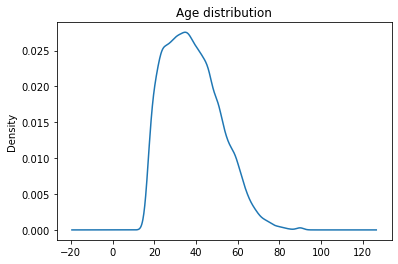

(30162, 13)
(30162, 12)


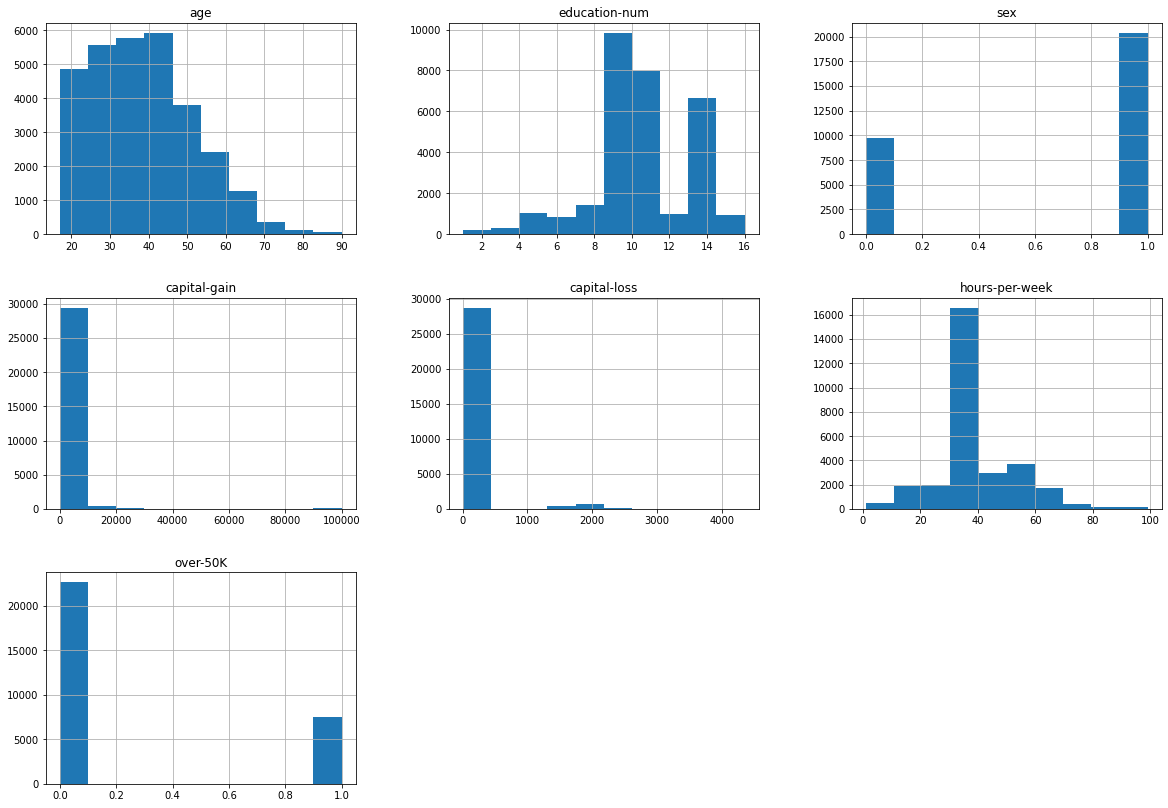

In [3]:
# Remove instances with missing/invalid data entries
dataset1_train.dropna(axis=0, how='any', inplace=True)
dataset1_test.dropna(axis=0, how='any', inplace=True)
print(dataset1_train.shape)

# Encode Over 20K as 1
dataset1_train['over-50K'] = dataset1_train['over-50K'].map({'>50K': 1, '<=50K': 0})
dataset1_test['over-50K'] = dataset1_test['over-50K'].map({'>50K': 1, '<=50K': 0})

# Encode Male as 1
dataset1_train['sex'] = dataset1_train['sex'].map({'Male': 1, 'Female': 0})
dataset1_test['sex'] = dataset1_test['sex'].map({'Male': 1, 'Female': 0})

print(dataset1_train['native-country'].describe()) 
# Since 91% of native-country data is US, we will categorize this column as "US" and "non-US".

# Encode US as 1 and non-US as 0
dataset1_train['native-country'] = np.where(dataset1_train['native-country']=='United-States', 1, 0)
dataset1_test['native-country'] = np.where(dataset1_test['native-country']=='United-States', 1, 0)

# Correlation
correlations = dataset1_train.corr(method="pearson")
print(correlations)

# From the above correlations, we can interpret that 'fnlgwt' and 'native-country' are not relevant to predicting the salary as their correlation is below 0.09.

# Remove uncorrelated columns
dataset1_train = dataset1_train.drop(columns=['fnlwgt', 'native-country'])
dataset1_test = dataset1_test.drop(columns=['fnlwgt', 'native-country'])

# Visualize age distribution
dataset1_train.age.plot(kind='kde')
plt.title('Age distribution')
plt.show()

# Visualize all numerical categories
dataset1_train.hist(figsize=(20, 14))

# Visualize categorical data
dataset1_train['education'].value_counts()
pd.crosstab(dataset1_train['education-num'], columns=dataset1_train['education'])
print(dataset1_train.shape)

# Remove education-num as it gives no more information than education
dataset1_train = dataset1_train.drop(columns='education-num')
dataset1_test = dataset1_test.drop(columns='education-num')
print(dataset1_train.shape)

## One-hot encoding

In [4]:
import category_encoders as ce

# Convert discrete variables into multiple variables using one-hot encoding
# Discrete columns: workclass, education, marital-status, occupation, relationship, sex, native-country
encoder = ce.OneHotEncoder(cols=['workclass', 'education', 'marital-status', 'occupation', 'race', 'relationship'], use_cat_names=True)
train_encoded_1 = encoder.fit_transform(dataset1_train)
test_encoded_1 = encoder.transform(dataset1_test) 

names_1_encoded = train_encoded_1.columns

/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


                age  hours-per-week  capital-gain  capital-loss  \
count  27956.000000    27956.000000  27956.000000  27956.000000   
mean       0.000812        0.000430      0.001584     -0.001546   
std        1.001308        1.003110      1.004003      0.999080   
min       -1.632189       -0.147445     -0.218586     -3.333218   
25%       -0.794697       -0.147445     -0.218586     -0.077734   
50%       -0.109476       -0.147445     -0.218586     -0.077734   
75%        0.651881       -0.147445     -0.218586      0.339636   
max        3.925715       13.354578     10.555814      4.847229   

       workclass_State-gov  workclass_Self-emp-not-inc  workclass_Private  \
count         27956.000000                27956.000000       27956.000000   
mean              0.042173                    0.083453           0.738053   
std               0.200988                    0.276570           0.439702   
min               0.000000                    0.000000           0.000000   
25%        

'\n# Normalize training set\nx = train_encoded_1.values\nmin_max_scaler = preprocessing.MinMaxScaler()\nx_scaled = min_max_scaler.fit_transform(x)\nnormalized_dataset_1 = pd.DataFrame(x_scaled, columns=names_1_encoded)\n\n# Normalize test set\nx = test_encoded_1.values\nx_scaled = min_max_scaler.fit_transform(x)\nnormalized_dataset_1_test = pd.DataFrame(x_scaled, columns=names_1_encoded)\n'

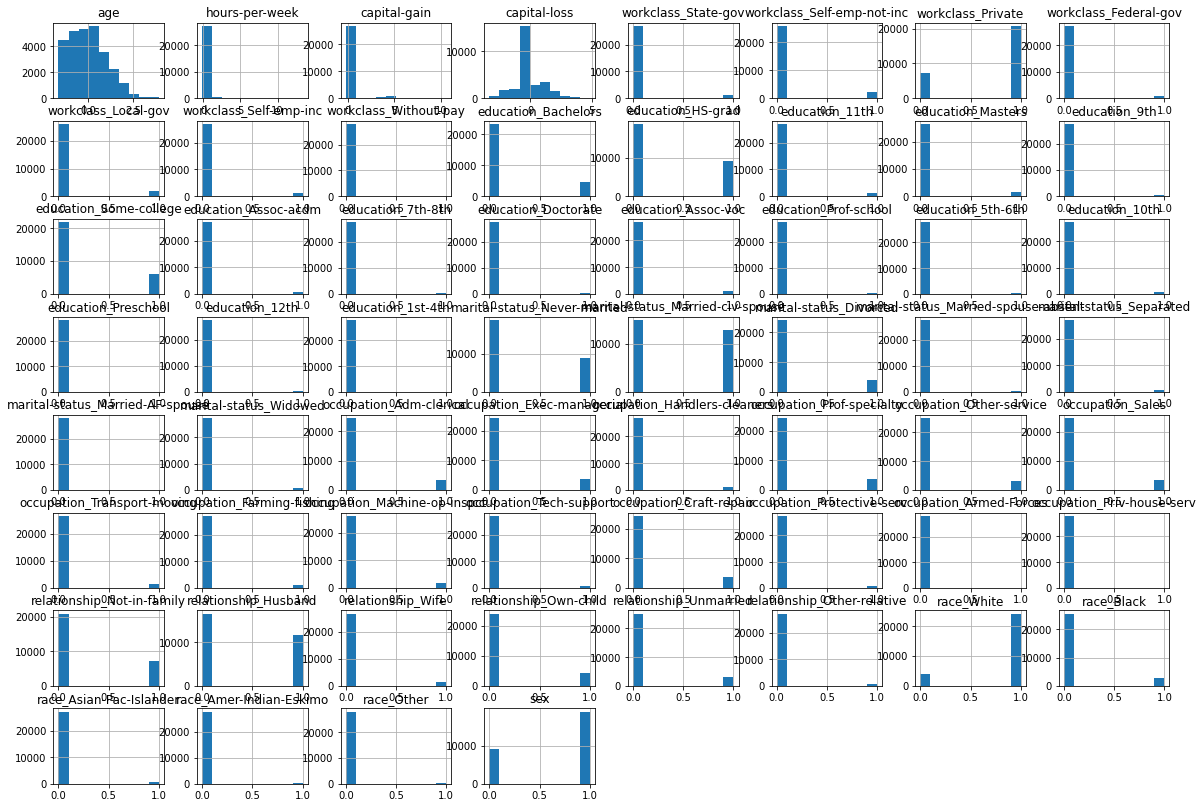

In [5]:
# Normalize
from sklearn import preprocessing
names1_x=['age', 'workclass_State-gov', 'workclass_Self-emp-not-inc',
       'workclass_Private', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Self-emp-inc', 'workclass_Without-pay',
       'education_Bachelors', 'education_HS-grad', 'education_11th',
       'education_Masters', 'education_9th', 'education_Some-college',
       'education_Assoc-acdm', 'education_7th-8th', 'education_Doctorate',
       'education_Assoc-voc', 'education_Prof-school', 'education_5th-6th',
       'education_10th', 'education_Preschool', 'education_12th',
       'education_1st-4th', 'marital-status_Never-married',
       'marital-status_Married-civ-spouse', 'marital-status_Divorced',
       'marital-status_Married-spouse-absent', 'marital-status_Separated',
       'marital-status_Married-AF-spouse', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Exec-managerial',
       'occupation_Handlers-cleaners', 'occupation_Prof-specialty',
       'occupation_Other-service', 'occupation_Sales',
       'occupation_Transport-moving', 'occupation_Farming-fishing',
       'occupation_Machine-op-inspct', 'occupation_Tech-support',
       'occupation_Craft-repair', 'occupation_Protective-serv',
       'occupation_Armed-Forces', 'occupation_Priv-house-serv',
       'relationship_Not-in-family', 'relationship_Husband',
       'relationship_Wife', 'relationship_Own-child', 'relationship_Unmarried',
       'relationship_Other-relative', 'race_White', 'race_Black',
       'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other',
       'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
x_d1=train_encoded_1.loc[:, 'age':'hours-per-week']
y_d1=train_encoded_1.loc[:,'over-50K']

unscaled_names=['workclass_State-gov', 'workclass_Self-emp-not-inc',
       'workclass_Private', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Self-emp-inc', 'workclass_Without-pay',
       'education_Bachelors', 'education_HS-grad', 'education_11th',
       'education_Masters', 'education_9th', 'education_Some-college',
       'education_Assoc-acdm', 'education_7th-8th', 'education_Doctorate',
       'education_Assoc-voc', 'education_Prof-school', 'education_5th-6th',
       'education_10th', 'education_Preschool', 'education_12th',
       'education_1st-4th', 'marital-status_Never-married',
       'marital-status_Married-civ-spouse', 'marital-status_Divorced',
       'marital-status_Married-spouse-absent', 'marital-status_Separated',
       'marital-status_Married-AF-spouse', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Exec-managerial',
       'occupation_Handlers-cleaners', 'occupation_Prof-specialty',
       'occupation_Other-service', 'occupation_Sales',
       'occupation_Transport-moving', 'occupation_Farming-fishing',
       'occupation_Machine-op-inspct', 'occupation_Tech-support',
       'occupation_Craft-repair', 'occupation_Protective-serv',
       'occupation_Armed-Forces', 'occupation_Priv-house-serv',
       'relationship_Not-in-family', 'relationship_Husband',
       'relationship_Wife', 'relationship_Own-child', 'relationship_Unmarried',
       'relationship_Other-relative', 'race_White', 'race_Black',
       'race_Asian-Pac-Islander', 'race_Amer-Indian-Eskimo', 'race_Other',
       'sex']

unscaled_data = x_d1.loc[:, 'workclass_State-gov':'sex']

scaler = preprocessing.StandardScaler()

# fit the scaler 
scaler.fit(x_d1.drop(unscaled_names, axis=1))

# transform the data
scaled_data = scaler.transform(x_d1.drop(unscaled_names, axis=1))
normalized_xd1 = pd.DataFrame(scaled_data, columns=['age', 'hours-per-week', 'capital-gain', 'capital-loss'])
normalized_xd1 = pd.concat([normalized_xd1, unscaled_data], axis=1, join="inner")

normalized_xd1.hist(figsize=(20, 14))
#y_d2.hist(figsize=(20,14))
print(normalized_xd1.describe())

'''
# Normalize training set
x = train_encoded_1.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1 = pd.DataFrame(x_scaled, columns=names_1_encoded)

# Normalize test set
x = test_encoded_1.values
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1_test = pd.DataFrame(x_scaled, columns=names_1_encoded)
'''

# Experiments


## Cross Validation helper function

In [6]:
# Note: Inspired from cross validation code given in class
def cross_validate(total_nval, n_folds=5):
    #get the number of data samples in each split
    n_val = total_nval // n_folds
    np.random.seed(0)
    inds = np.random.permutation(total_nval)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexess
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, total_nval))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

In [68]:
from sklearn.metrics import accuracy_score

def findBestK(x, y):
    (nb_instances, nb_features) = x.shape
    n_test, n_valid = nb_instances // 5, nb_instances // 5

    inds = np.random.permutation(nb_instances)
    x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
    x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
    n_rest = nb_instances - n_test 

    # Store number of remaining data for train and valid
    n_rest = nb_instances - n_test

    K_list = range(1, 30)
    num_folds = 5
    best_k = 0
    best_acc = 0
    for i, K in enumerate(K_list):
        # Find the validation errors for num_folds splits for a given K
        for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
            model = neighbors.KNeighborsClassifier(n_neighbors=K)
            model = model.fit(x_rest[tr], y_rest[tr])

            y_pred = model.predict(x_rest[val])
            acc = accuracy_score(y_pred, y_rest[val])

            if acc > best_acc:
                best_k = K
                best_acc = acc

    return best_acc, best_k

## KNN

In [8]:
# Split the data
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True)

# Split further for testing purposes (growing samples)
data_30 = train_encoded_1.sample(frac=0.30)
x_30, y_30 = data_30.iloc[:,:-1].to_numpy(), data_30['over-50K'].to_numpy()
x_train_30, x_test_30, y_train_30, y_test_30 = train_test_split(x_30, y_30, test_size=0.15, shuffle=True)

data_20 = train_encoded_1.sample(frac=0.20)
x_20, y_20 = data_20.iloc[:,:-1].to_numpy(), data_20['over-50K'].to_numpy()
x_train_20, x_test_20, y_train_20, y_test_20 = train_test_split(x_20, y_20, test_size=0.15, shuffle=True)

data_10 = train_encoded_1.sample(frac=0.10)
x_10, y_10 = data_10.iloc[:,:-1].to_numpy(), data_10['over-50K'].to_numpy()
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_10, y_10, test_size=0.15, shuffle=True)


print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

'''
x_normalized, y_normalized = normalized_xd1.iloc[:,:-1].to_numpy(), normalized_xd1['over-50K'].to_numpy()
x_normalized_train, x_normalized_test, y_normalized_train, y_normalized_test = train_test_split(x_normalized, y_normalized, test_size=0.15, shuffle=True)
print(x_normalized_train.shape, x_normalized_test.shape)
print(y_normalized_train.shape, y_normalized_test.shape)
'''


(25637, 60) (4525, 60)
(25637,) (4525,)


"\nx_normalized, y_normalized = normalized_xd1.iloc[:,:-1].to_numpy(), normalized_xd1['over-50K'].to_numpy()\nx_normalized_train, x_normalized_test, y_normalized_train, y_normalized_test = train_test_split(x_normalized, y_normalized, test_size=0.15, shuffle=True)\nprint(x_normalized_train.shape, x_normalized_test.shape)\nprint(y_normalized_train.shape, y_normalized_test.shape)\n"

In [70]:
# With 10% of data
best_acc, best_k = findBestK(x_10, y_10)
print('10 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (unormalized)')
print('-------------------------------------------------------------------------------------------\n')

# With 20% of data
best_acc, best_k = findBestK(x_20, y_20)
print('20 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (unormalized)')
print('-------------------------------------------------------------------------------------------\n')

# With 30% of data
best_acc, best_k = findBestK(x_30, y_30)
print('30 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (unormalized)')
print('-------------------------------------------------------------------------------------------\n')

# With 100% of data
best_acc, best_k = findBestK(x, y)
print('100 percent of data\n' f'Best cross validation accuracy : {best_acc:.3f} found with K = {best_k} (unormalized)')

10 percent of data
Best cross validation accuracy : 0.859 found with K = 13 (unormalized)
-------------------------------------------------------------------------------------------

10 percent of data
Best cross validation accuracy : 0.872 found with K = 2 (unormalized)
-------------------------------------------------------------------------------------------

10 percent of data
Best cross validation accuracy : 0.854 found with K = 4 (unormalized)
-------------------------------------------------------------------------------------------

10 percent of data
Best cross validation accuracy : 0.848 found with K = 8 (unormalized)


In [ ]:
# Graph differences in accuracy for growing samples

In [ ]:
# Normalized data (10%, 20%, 30%, 100%)

In [ ]:
# Compare normalized vs unormalized

In [13]:
# EXTRA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(x, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

## Confusion matrix

In [ ]:
from sklearn import tree, model_selection
x, y = datasets.load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)
yh_test = tree.DecisionTreeClassifier().fit(x_train, y_train).predict(x_test)

def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

cmat = confusion_matrix(y_test, yh_test)
print(cmat)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

## Decision Tree